## Fiber Photometry
1. Date: Recording - 2024/05/16, Analysis - 2024/05/22
2. Task: 3-Chamber test, E-E session
3. Performer: Recording - YGKim, Analysis - YGKim
4. Animal: CHD8 HT male, DOB 23/11/?? 
5. Group, ID: 710M

### 1. Import libraries

In [219]:
# import the libraries that we will use
import os
import pandas as pd
import numpy as  np
import pylab as plt
import seaborn as sns
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

# import the tdt library
import tdt

In [220]:
# get help on the function tdt.read_block()
# tdt.read_block?

### 2. Import data

In [221]:
block_path = 'C:/TDT/Synapse/Tanks/JJ-YG-Experimental Data/JJ-YG-Experimental Data/PV-Cre-240516-162554'
block_path

'C:/TDT/Synapse/Tanks/JJ-YG-Experimental Data/JJ-YG-Experimental Data/PV-Cre-240516-162554'

In [222]:
FPdata = tdt.read_block(block_path)
FPdata

Found Synapse note file: C:/TDT/Synapse/Tanks/JJ-YG-Experimental Data/JJ-YG-Experimental Data/PV-Cre-240516-162554\Notes.txt
read from t=0s to t=668.16s


epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

### 3. Browse data 

위의 한 줄 코드로 block 내의 모든 데이터 반입. 반입된 data는 structured object(dictionary type in Python)임.</br>
데이터 크기가 크다면 그 중 일부만 반입하는 것도 가능. 자세한 내용은 도움말 참고. </br>
tdt.read_block(PATH_BLOCK).info 명령어로 data에 대한 자세한 정보 확인 가능. 

In [223]:
FPdata.info # 계층구조를 가지는 데이터셋으로 '.' (dot) expression을 통해서 각 수준의 데이터에 접근 가능

tankpath:	'C:\\TDT\\Synapse\\Tanks\\JJ-YG-Experimental Data\\JJ-YG-Experimental Data'
blockname:	'PV-Cre-240516-162554'
start_date:	datetime.datetime(2024, 5, 16, 16, 26, 0, 999999)
utc_start_time:	'16:26:00'
stop_date:	datetime.datetime(2024, 5, 16, 16, 37, 9, 159566)
utc_stop_time:	'16:37:09'
duration:	datetime.timedelta(seconds=668, microseconds=159567)
stream_channel:	0
snip_channel:	0
experiment:	'JJ-YG'
subject:	'PV-Cre'
user:	'User'
start:	'4:26:01오후 05/16/2024'
stop:	'4:37:10오후 05/16/2024'

Epoch 데이터에 접근

In [224]:
FPdata.epocs

Pu1_	[struct]
PtC0	[struct]
Cam1	[struct]

In [225]:
FPdata.epocs['PtC0'] #PtC0 onset data가 camera trigger signal로 사용됨.

name:	'PtC0'
onset:	array([  4.7972352 ,   4.82852864,   4.85982208, ..., 665.02623232,
       665.05752576, 665.0888192 ])
offset:	array([  4.82852864,   4.85982208,   4.89111552, ..., 665.05752576,
       665.0888192 ,          inf])
type:	'onset'
type_str:	'epocs'
data:	array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 2.1099e+04, 2.1100e+04,
       2.1101e+04])
dform:	4
size:	10

In [226]:
# camera frame per second는 32, 10분 녹화시 tick의 길이는 총 19200
CamTick = FPdata.epocs.PtC0.onset[0:19200]
CamTick

array([  4.7972352 ,   4.82852864,   4.85982208, ..., 605.53740288,
       605.56869632, 605.59998976])

Streams 데이터에 접근

In [227]:
FPdata.streams['_405A']

name:	'_405A'
code:	1094004788
size:	138
type:	33025
type_str:	'streams'
ucf:	False
fs:	1017.2526245117188
dform:	0
start_time:	0.0
data:	array([ 0.5201312 ,  0.5173203 ,  0.51454353, ..., 35.836567  ,
       35.81847   , 35.80163   ], dtype=float32)
channel:	[1]

In [228]:
# export isosbestic and GCaMP signals
control_whole = FPdata.streams['_405A'].data
signal_whole = FPdata.streams['_465A'].data
control_whole, signal_whole

(array([ 0.5201312 ,  0.5173203 ,  0.51454353, ..., 35.836567  ,
        35.81847   , 35.80163   ], dtype=float32),
 array([ 0.8194988 ,  0.811132  ,  0.80211496, ..., 37.569275  ,
        37.56902   , 37.56865   ], dtype=float32))

In [229]:
#control sample 수 확인
num_sample = len(control_whole)
num_sample

679552

In [230]:
#control sampling rate 확인
sampling_rate = FPdata.streams['_405A'].fs
print(sampling_rate)

1017.2526245117188


In [231]:
# time array 생성
time_seconds = np.linspace(1, num_sample, num_sample)/sampling_rate
print(time_seconds)

[9.83039980e-04 1.96607996e-03 2.94911994e-03 ... 6.68024819e+02
 6.68025802e+02 6.68026785e+02]


In [232]:
# 행동 데이터가 존재하는 time array 추출
time_sec = time_seconds[np.max(np.where(time_seconds <= CamTick[0])) : np.min(np.where(time_seconds >= CamTick[19199]))+1]
print(time_sec)

[  4.7972351    4.79821814   4.79920118 ... 605.59883077 605.59981381
 605.60079685]


In [233]:
control_raw = control_whole[np.max(np.where(time_seconds <= CamTick[0])) : np.min(np.where(time_seconds >= CamTick[19199]))+1]
signal_raw = signal_whole[np.max(np.where(time_seconds <= CamTick[0])) : np.min(np.where(time_seconds >= CamTick[19199]))+1]
control_raw, len(control_raw), signal_raw, len(signal_raw)

(array([42.559036, 42.579445, 42.59989 , ..., 36.402252, 36.409332,
        36.416218], dtype=float32),
 611170,
 array([42.823544, 42.839844, 42.856045, ..., 37.696842, 37.70337 ,
        37.709545], dtype=float32),
 611170)

Let's take a look at the raw GCaMP and isosbestic control signals.

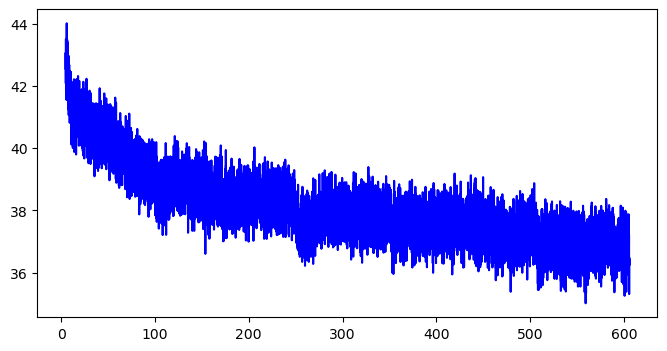

In [234]:
fig_405A = plt.subplots(figsize=(8,4))
plt.plot(time_sec, control_raw, 'b')
plt.show()

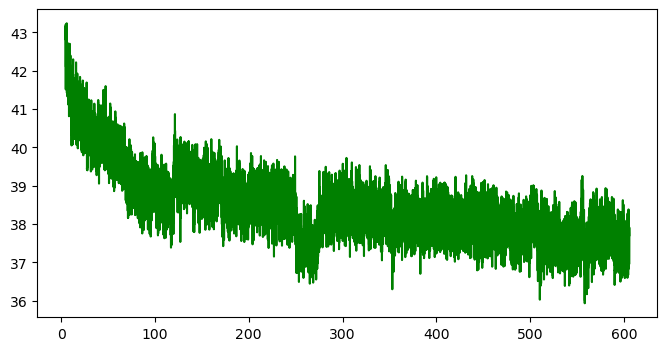

In [235]:
fig_465A = plt.subplots(figsize=(8,4))
plt.plot(time_sec, signal_raw, 'g')
plt.show()

Or we can browse them at the same time in a merged plot.

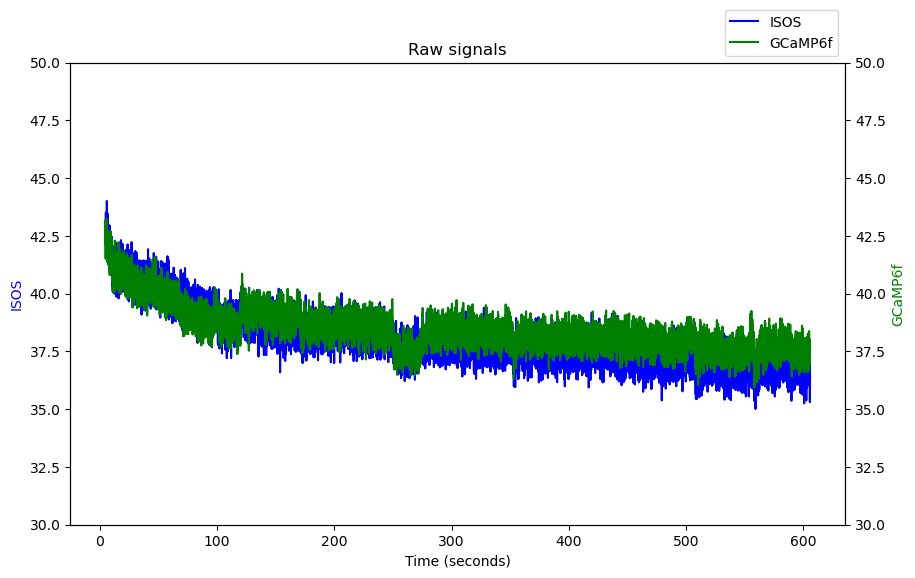

In [236]:
# plot signals
fig,ax1=plt.subplots(figsize=(10,6))  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time_sec, control_raw, 'b', label='ISOS') #plot Isosbestic signal on left y-axis
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time_sec, signal_raw, 'g', label='GCaMP6f') # plot GCaMP signal on right y-axis

# Plot image acquisition times as ticks.
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 50), label='camera ticks', color='w', marker="|", mec='k')


ax1.set_ylim(30, 50)
# ax1.set_xlim(5, 10) # 초단위로 입력하여 x-axis zoom in 가능 
ax2.set_ylim(30, 50)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('ISOS', color='b')
ax2.set_ylabel('GCaMP6f', color='g')
ax1.set_title('Raw signals')

lines = plot1 + plot2 #+camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

In [237]:
FPdata.epocs.Cam1

name:	'Cam1'
onset:	array([9.91232000e-02, 3.05725440e-01, 4.98237440e-01, ...,
       6.67652260e+02, 6.67845263e+02, 6.68059566e+02])
offset:	array([3.05725440e-01, 4.98237440e-01, 7.28432640e-01, ...,
       6.67845263e+02, 6.68059566e+02,            inf])
type:	'onset'
type_str:	'epocs'
data:	array([1.000e+00, 2.000e+00, 4.000e+00, ..., 6.638e+03, 6.640e+03,
       6.642e+03])
dform:	4
size:	10

In [238]:
data = {'onset':FPdata.epocs.Cam1.onset, 'offset': FPdata.epocs.Cam1.offset}
df_Cam_ticks = pd.DataFrame(data=data)
df_Cam_ticks

,onset,offset
0,0.099123,0.305725
1,0.305725,0.498237
2,0.498237,0.728433
3,0.728433,0.905544
4,0.905544,1.114931
...,...,...
3317,667.258552,667.443200
3318,667.443200,667.652260
3319,667.652260,667.845263
3320,667.845263,668.059566


In [239]:
# df_Cam_ticks.to_csv('79M_WT_Cam1.csv', header=False)

### 3. Denoising
#### 3-1. Smoothing (Filtering)
In general, the kinetics of physiological signals are slower than that of noise in the recorded signal. In other words, meaningful signals are usually present in the low-frequency components of the recorded signal, whereas noise is present at all frequencies. So, by using low-pass filter, we are able to improve the signal-to-noise ratio of our result. At this step, there are several options available. We can use Zero Phase filtering, Fast Fourier transform, or, simply, Savitzky-Golay filter.  

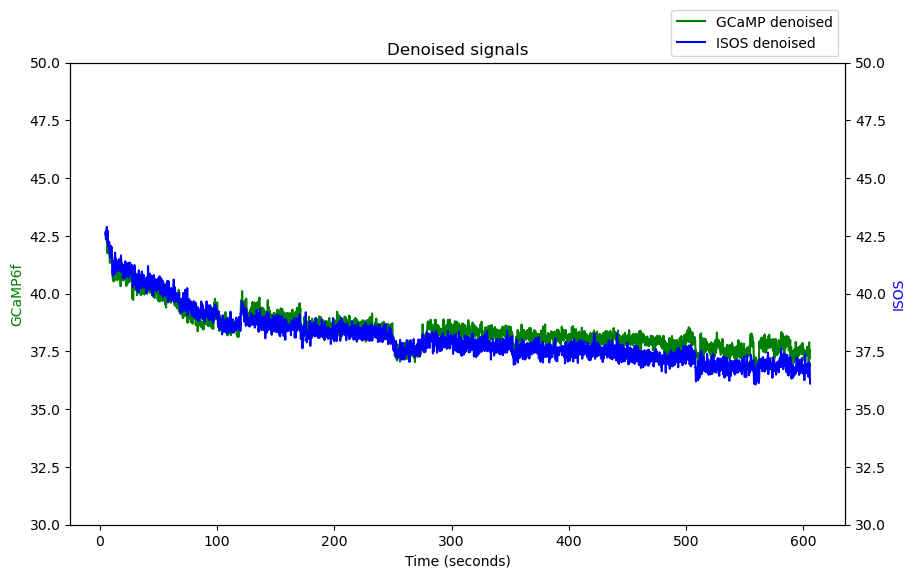

In [240]:
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 2, btype='low', fs=sampling_rate)
signal_denoised = filtfilt(b,a, signal_raw)
control_denoised = filtfilt(b,a, control_raw)

fig,ax1=plt.subplots(figsize=(10,6))
plot1=ax1.plot(time_sec, signal_denoised, 'g', label='GCaMP denoised')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_denoised, 'b', label='ISOS denoised')
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 50), label='camera tick', color='w', marker="|", mec='k', ms=10)

ax1.set_ylim(30, 50)
ax2.set_ylim(30, 50)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Denoised signals')

lines = plot1+plot2 #+camera_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1)) #add legend

Let's zoom in on the x-axis to see how the lowpass filtering has smoothed the signals.

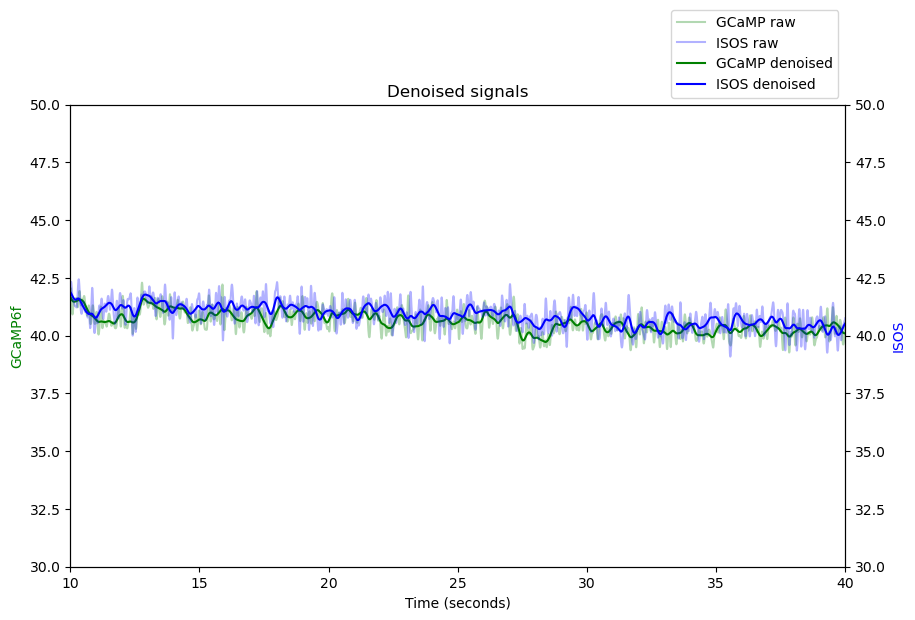

In [241]:
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_raw, color='g', alpha=0.3, label='GCaMP raw')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_raw, color='b', alpha=0.3, label='ISOS raw') 
plot3=ax1.plot(time_sec, signal_denoised, color='g', label='GCaMP denoised') 
plot4=ax2.plot(time_sec, control_denoised, color='b', label='ISOS denoised') 
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 80), label='camera tick',color='w', marker="|", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Denoised signals')

lines = plot1+plot2 + plot3 + plot4 #+ camera_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1))
ax1.set_xlim(10, 40) # 60 sec window
ax1.set_ylim(30, 50)
ax2.set_ylim(30, 50);

#### 3-2. Photobleaching correction (or Detrending)
Now let's compare some different ways of removing the influence of photobleaching

##### Method 1: Double Exponential Fit
One way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal (note, some groups divide the signal by the baseline rather than subtracting the baseline, see Fiber Photometry Primer for more discussion). In practice we find that a double exponential fit is preferable to a single exponential fit because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

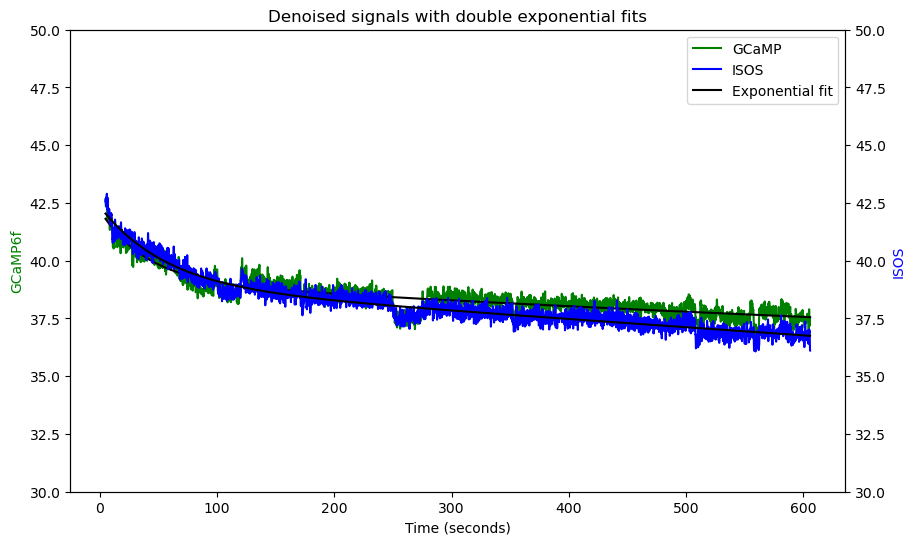

In [242]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to GCaMP6f signal.
max_sig = np.max(signal_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
signal_parms, parm_cov = curve_fit(double_exponential, time_sec, signal_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
signal_expfit = double_exponential(time_sec, *signal_parms)

# Fit curve to Isosbestic signal.
max_sig = np.max(control_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
control_parms, parm_cov = curve_fit(double_exponential, time_sec, control_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
control_expfit = double_exponential(time_sec, *control_parms)

#plot fits over denoised data
fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_denoised, 'g', label='GCaMP')
plot3=ax1.plot(time_sec, signal_expfit, color='k', linewidth=1.5, label='Exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_denoised, color='b', label='ISOS') 
plot4=ax2.plot(time_sec, control_expfit,color='k', linewidth=1.5) 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Denoised signals with double exponential fits')

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(30, 50)
ax2.set_ylim(30, 50);

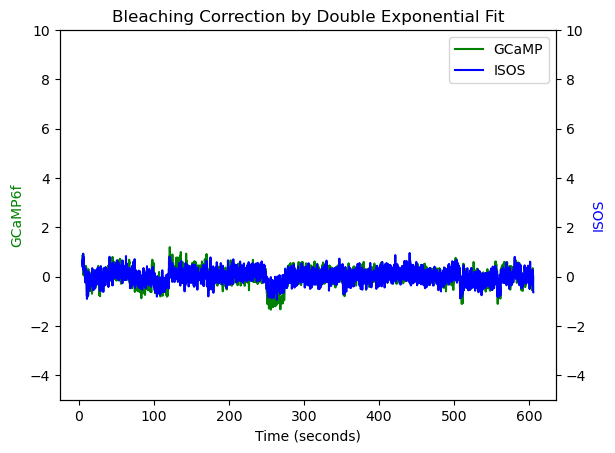

In [243]:
signal_detrended = signal_denoised - signal_expfit
control_detrended = control_denoised - control_expfit

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_sec, signal_detrended, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_detrended, color='b', label='ISOS') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Bleaching Correction by Double Exponential Fit')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(-5, 10)
ax2.set_ylim(-5, 10);

##### Method 2: High Pass Filter
A simpler way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes. All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

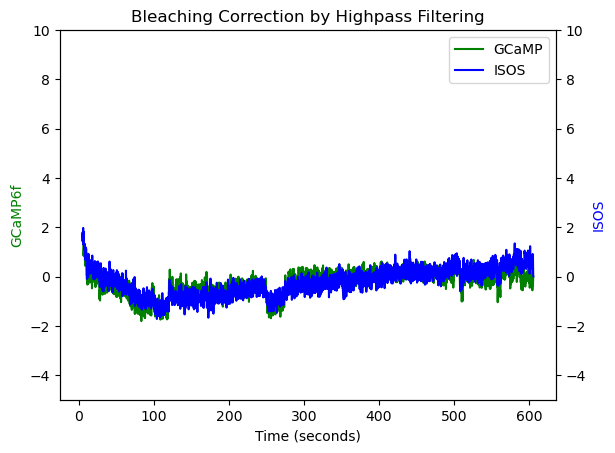

In [244]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
signal_highpass = filtfilt(b,a, signal_denoised, padtype='even')
control_highpass = filtfilt(b,a, control_denoised, padtype='even')

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_sec, signal_highpass, 'g', label='GCaMP')
ax2=plt.twinx()
plot2=ax2.plot(time_sec, control_highpass, color='b', label='ISOS') 

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax2.set_ylabel('ISOS', color='b')
ax1.set_title('Bleaching Correction by Highpass Filtering')

lines = plot1+plot2 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right'); 
ax1.set_ylim(-5, 10)
ax2.set_ylim(-5, 10);

#### 3-3. Motion correction
We now do motion correction by finding the best linear fit of the 405 signal to the GCaMP6f signal and subtracting this estimated motion component from the GaMP6f signal. We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful slow variation in the signals.

Slope    : 0.621
R-squared: 0.240


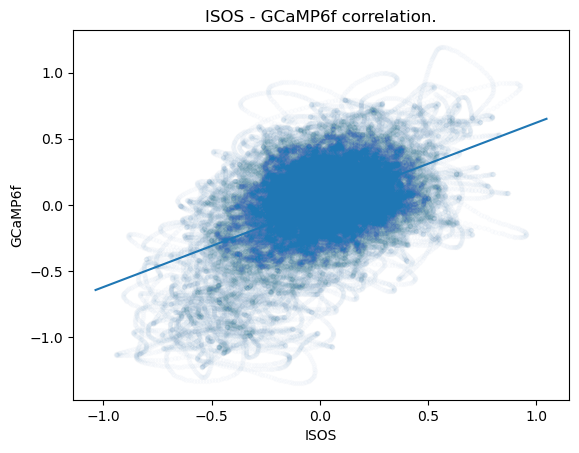

In [245]:
slope, intercept, r_value, p_value, std_err = linregress(x=control_detrended, y=signal_detrended)

plt.scatter(control_detrended[::5], signal_detrended[::5],alpha=0.01, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('ISOS')
plt.ylabel('GCaMP6f')
plt.title('ISOS - GCaMP6f correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

We now calculate the estimated motion component of the GCaMP signal and subtract to get the motion corrected signal.

(10.0, 60.0)

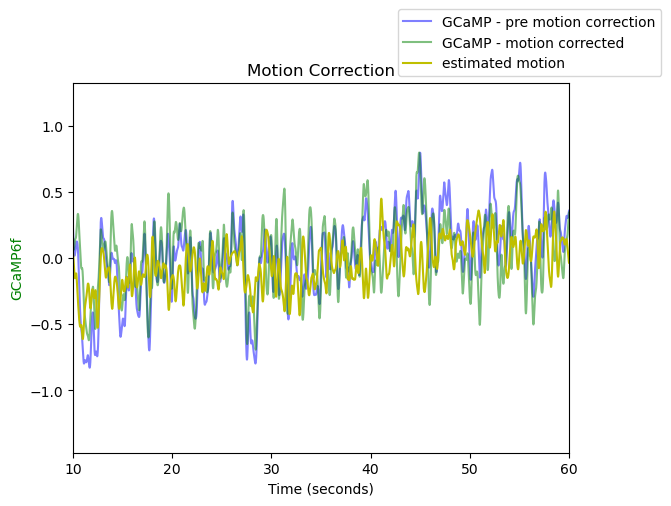

In [246]:
signal_est_motion = intercept + slope * control_detrended
signal_corrected = signal_detrended - signal_est_motion

fig,ax1=plt.subplots()  
plot1=ax1.plot(time_sec, signal_detrended, 'b' , label='GCaMP - pre motion correction', alpha=0.5)
plot3=ax1.plot(time_sec, signal_corrected, 'g', label='GCaMP - motion corrected', alpha=0.5)
plot4=ax1.plot(time_sec, signal_est_motion - 0.05, 'y', label='estimated motion')
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 2), label='Camera tick',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP6f', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4 #+ camera_ticks
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1.2, 1))

ax1.set_xlim(10, 60)  # 60 sec window
# ax1.set_ylim(-0.075, 0.1);

### 4. Normalization

Typically in a photometry experiment we want to combine data across sessions and/or subjects. This is complicated by the fact that different sessions may have different levels of fluorphore expression, excitation light and autofluorescence. It is therefore desirable to normalise the data to reduce this variability. The two most widely used ways of doing this are computing dF/F or z-scores.

#### Method 1: dF/F
To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above. The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

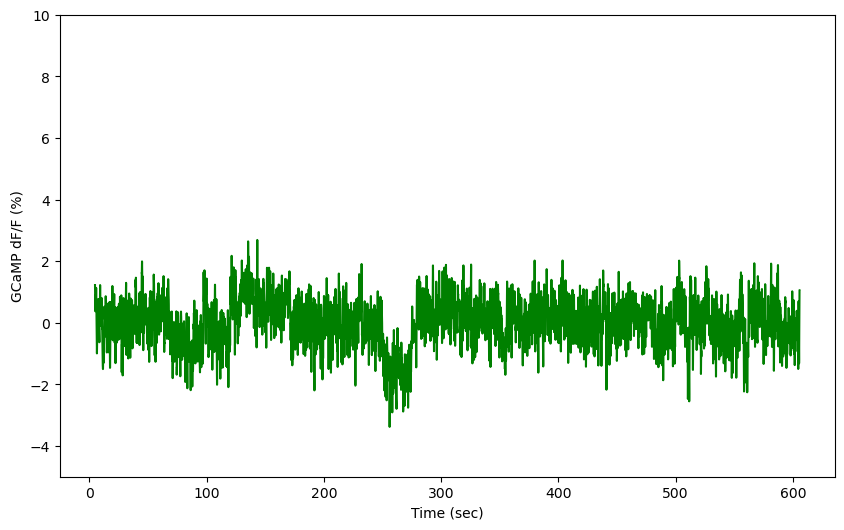

In [247]:
signal_dF_F = 100*signal_corrected/signal_expfit

fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_dF_F, 'g', label='GCaMP dF/F')
# camera_ticks = ax1.plot(FPdata.epocs.Cam1.onset, np.full(np.size(FPdata.epocs.Cam1.onset), 2), label='Camera tick',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('GCaMP dF/F (%)')
# ax1.set_title('GCaMP dF/F')

lines = plot1
labels = [l.get_label() for l in lines]  
# legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

# sns.set(font_scale=1)
# ax1.set_xlim(0, 600)
ax1.set_ylim(-5, 10);

#### Method 2: Z-scoring

Alternatively, we can normalise the data by z-scoring each session - i.e. subtracting the mean and dividing by the standard deviation.

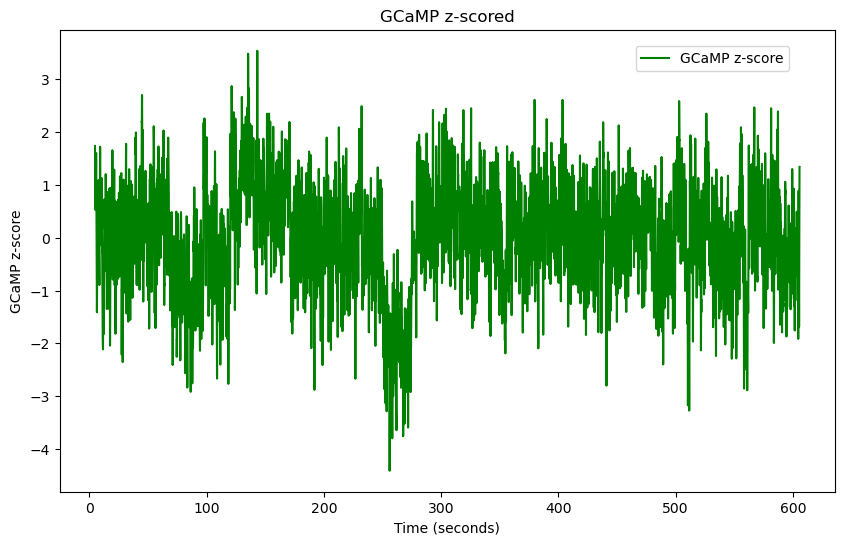

In [248]:
signal_zscored = (signal_corrected-np.mean(signal_corrected))/np.std(signal_corrected)


fig,ax1=plt.subplots(figsize=(10,6))  
plot1=ax1.plot(time_sec, signal_zscored, 'g', label='GCaMP z-score')
# reward_ticks = ax1.plot(reward_cue_times, np.full(np.size(reward_cue_times), 6), label='Reward Cue',color='w', marker="v", mfc='k', mec='k', ms=8)

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP z-score')
ax1.set_title('GCaMP z-scored')

lines = plot1
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

# ax1.set_xlim(10, 70)
# ax1.set_ylim(-3, 7);

### 5. Analysis & Statistical testing
#### Epoch averaging

In [ ]:
df_position = pd.read_csv('./240403_153010_Cam1.csv', header=0, index_col=0)
df_position.head()

In [ ]:
# 낮은 샘플링 속도의 camera ticks
Camera_tick = pd.DataFrame({
    'onset': FPdata.epocs.Cam1.onset,
    'offset': FPdata.epocs.Cam1.offset, 
    'location': df_position.roi.iloc[0:len(FPdata.epocs.Cam1.onset)]  
})

# 높은 샘플링 속도의 GCaMP signal
GCaMP_signal = pd.DataFrame({
    'time': time_seconds_1,  
    'value': signal_dF_F  
})


# 판정 결과를 높은 샘플링 속도의 데이터셋에 추가
GCaMP_signal['location'] = ""  # 판정 결과를 저장할 열을 추가하고 초기값을 False로 설정


# 낮은 샘플링 속도의 데이터셋의 각 시간 범위에 대해 해당 범위 내의 높은 샘플링 속도의 데이터를 추출하여 판정 결과 업데이트
for index, row in Camera_tick.iterrows():
    start_time = row['onset']
    end_time = start_time + row['offset']  # 낮은 샘플링 속도의 데이터셋은 5분 간격으로 측정되므로 범위를 5분으로 설정
    
    # 해당 시간 범위 내의 높은 샘플링 속도의 데이터를 추출하여 판정 결과 업데이트
    GCaMP_signal.loc[(GCaMP_signal['time'] >= start_time) & 
                                (GCaMP_signal['time'] < end_time), 'location'] = row['location']

# 결과 출력
print("Camera_tick:")
print(Camera_tick)
print("\nGCaMP_signal:")
print(GCaMP_signal)

In [ ]:
print("mean dF/F in Middle zone:")
print(GCaMP_signal[GCaMP_signal['location']=='Middle']['value'].mean())
print("\nmean dF/F in S1 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='S_1']['value'].mean())
print("\nmean dF/F in O1 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='O_1']['value'].mean())
print("\nmean dF/F in S2 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='S_2']['value'].mean())
print("\nmean dF/F in S3 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='S_3']['value'].mean())
print("\nmean dF/F in O2 zone:")
print(GCaMP_signal[GCaMP_signal['location']=='O_2']['value'].mean())

In [ ]:
print("averaged dF/F in S1+S2 zone:")
print(GCaMP_signal[(GCaMP_signal['location']=='S_1')&(GCaMP_signal['location']=='S_2')]['value'].mean())
print("\naveraged dF/F in O1+O2 zone:")
print(GCaMP_signal[(GCaMP_signal['location']=='O_1')&(GCaMP_signal['location']=='O_2')]['value'].mean())

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.set_context(font_scale=100)
boxplot=sns.boxplot(data=GCaMP_signal, 
                      x='location', 
                      y='value',
                      order=['S_1', 'S_2', 'S_3', 'Middle', 'O_2', 'O_1'])
boxplot.set(xlabel='ROI', ylabel='dF/F', ylim=(-6, 9), title='PV-Cre 1F')

sns.set(font_scale=2)

plt.show()

In [ ]:
# 이벤트들과 그 시간을 포함한 데이터프레임 생성
events_data = {
    'event': df_position.transition_index[0:len(FPdata.epocs.Cam1.onset)],
    'event_time': FPdata.epocs.Cam1.onset
}
events_df = pd.DataFrame(events_data)

# 선택한 이벤트
selected_event = 2

# 선택한 이벤트에 해당하는 행 필터링
selected_events_data = events_df[events_df['event'] == selected_event]

# 그래프 생성
plt.figure(figsize=(10, 6))


# 각 이벤트에 대해 데이터를 추출하고 lineplot으로 그림
all_lines = []  

# 모든 line들을 저장하기 위한 리스트
for index, row in selected_events_data.iterrows():
    selected_event_time = row['event_time']

    # 이벤트 발생 시간을 기준으로 10초 전부터 20초 후까지의 데이터 추출
    start_time = selected_event_time - 10
    end_time = selected_event_time + 20
    filtered_data = GCaMP_signal[(GCaMP_signal['time'] >= start_time) & (GCaMP_signal['time'] <= end_time)]

    # 시간을 조정하여 데이터 시점을 맞춤
    filtered_data['time'] -= selected_event_time

    # lineplot 그리기 (투명도를 조절하여 녹색으로 표시)
    x_data = filtered_data['time']
    y_data = filtered_data['value']
    
    line, = plt.plot(x_data, y_data, color='green', alpha=0.1)
    all_lines.append(y_data.values)  # 각 시점에서의 데이터들을 저장

# 모든 시점에서의 데이터들을 2차원 배열로 변환
all_lines = pd.DataFrame(all_lines)

# 각 시점에서의 데이터들의 평균값 계산
mean_values = all_lines.mean(axis=0)

# x_data는 시간 데이터로 공통이므로, 처음 시점에서만 가져옴
x_data = filtered_data['time']

# 각 시점에서의 데이터들의 평균값을 녹색선으로 표시
min_length = min(len(x_data), len(mean_values))
x_data = x_data[:min_length]
mean_values = mean_values[:min_length]

plt.plot(x_data, mean_values, color='green', label='Mean Value', linewidth=4)

# 각 이벤트에 대해 lineplot으로 그림 (투명도를 조절하여 녹색으로 표시)
# for index, row in selected_events_data.iterrows():
#     selected_event_time = row['event_time']
#     start_time = selected_event_time - 10
#     end_time = selected_event_time + 20
#     plt.plot(filtered_data['time'], filtered_data['value'], color='green', alpha=0.1)

# 그래프 제목과 레이블 추가
plt.title('PV-Cre_1F')
plt.xlabel('Time (sec)')
plt.ylabel('GCaMP dF/F (%)')

# 범례 추가
# plt.legend()

# 그래프 출력
plt.grid(True)
plt.show()